Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this exercise we are using high level abstractions from torch.nn like nn.Linear.
Note: during the next lab session we will go one level deeper and implement more things
with bare hands.

Tasks:

    1. Read the code.

    2. Check that the given implementation reaches 95% test accuracy for architecture input-128-128-10 after few epochs.

    3. Add the option to use SGD with momentum instead of ADAM.

    4. Experiment with different learning rates, plot the learning curves for different
    learning rates for both ADAM and SGD with momentum.

    5. Parameterize the constructor by a list of sizes of hidden layers of the MLP.
    Note that this requires creating a list of layers as an atribute of the Net class,
    and one can't use a standard python list containing nn.Modules (why?).
    Check torch.nn.ModuleList.


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [26]:
class Net(nn.Module):
    def __init__(self, sizes):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        self.linears = nn.ModuleList([nn.Linear(in_size, out_size) for in_size, out_size in zip(sizes, sizes[1:])])

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linears[0](x)

        for lin in self.linears[1:]:
            x = F.relu(x)
            x = lin(x)
                 
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return sum(losses)/len(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)



In [27]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 1e-2
momentum = 0.9
use_cuda = False
seed = 1
log_interval = 10

In [28]:
use_cuda = not use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [29]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [30]:
model = Net([784, 128, 128, 10]).to(device)
which_optimizer = 'SGD'

if which_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
elif which_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
else:
    raise Exception('not correct optimizer chosen')

In [31]:
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
    test_loss, test_accuracy = test(model, device, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313259
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.199515
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.891006
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.361914
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.776012
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.724128
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.461711
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.381140
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.454913
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.389780
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.356318
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.486098
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.415067
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.403497
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.339863
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.364892
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.306344
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.255656
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.431167
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.201018
Train Epoc

<function matplotlib.pyplot.show>

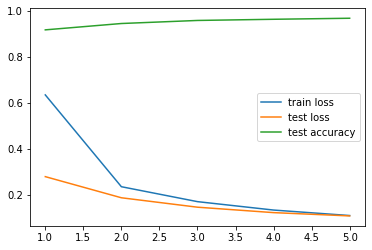

In [32]:
import matplotlib.pyplot as plt

xs = range(1, len(train_losses)+1)
plt.plot(xs, train_losses, label='train loss')
plt.plot(xs, test_losses, label='test loss')
plt.plot(xs, test_accuracies, label='test accuracy')
plt.legend()
plt.show